## Walktimes to CCC
# Introduction

In this tutorial we will analyse walk times from bike_TE points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. CCCs can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including CCC (https://open.toronto.ca/dataset/ttc-routes-and-schedules/), the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One bike_TE Repository bike_TE point data (https://open.toronto.ca/dataset/bike_TE-points-municipal-toronto-one-bike_TE-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/).

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto bike_TE point data contains over 500,000 bike_TE points within the city. A readme file is also included which explains the each of the attributes.

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).

In [ ]:
!pip install geopandas

In [ ]:
!pip install psycopg2

In [ ]:
!pip install pandana

In [ ]:
!pip install basemap --user

In [ ]:
!pip install geoalchemy2

In [ ]:
!pip install mapclassify

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import Polygon, LineString, Point, box
%matplotlib inline

## Step 1: Importing and Cleaning Data
# Importing Data
We can read the CCC text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, bike_TE and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

# Read CCC Data
Read the CCC data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [2]:
# reading CCC csv file
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# Go to Download Data
ccc = pd.read_csv('Child care centres - 2945.csv')
ccc

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,21APR22,"{'type': 'Point', 'coordinates': (-1392098.168..."
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,21APR22,"{'type': 'Point', 'coordinates': (-1382218.055..."
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,21APR22,"{'type': 'Point', 'coordinates': (-1359925.521..."
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,(416) 415-2453,Other,NaN,10,15,40,0,0,65,Y,21APR22,"{'type': 'Point', 'coordinates': (-1380912.770..."
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,(416) 694-1138x163,High Rise Apartment,NaN,0,10,16,0,0,26,Y,21APR22,"{'type': 'Point', 'coordinates': (-1371061.855..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1042,14333,Gan Chabad Preschool,Non Profit Agency,147 OVERBROOK PL,M3H 4R1,6,(416) 635-9696,Other,NaN,0,15,43,0,0,58,N,21APR22,"{'type': 'Point', 'coordinates': (-1383573.055..."
1042,1043,14335,Atelier Kids Inc.,Commercial Agency,21 QUEBEC AVE,M6P 2T3,4,(416) 419-3864,Other,NaN,0,0,20,24,0,44,N,21APR22,"{'type': 'Point', 'coordinates': (-1387496.926..."
1043,1044,14336,Westside Montessori School,Commercial Agency,57 SYLVAN AVE,M6H 1G4,9,(647) 400-6521,Other,NaN,0,12,23,0,0,35,N,21APR22,"{'type': 'Point', 'coordinates': (-1384701.776..."
1044,1045,14338,The Neighbourhood Group Harbourfront Child Care,Non Profit Agency,650 QUEENS QUAY W,M5V 3N2,10,NaN,High Rise Apartment,NaN,16,20,0,0,0,36,Y,21APR22,"{'type': 'Point', 'coordinates': (-1382536.037..."


In [3]:
# Let's check out the .shp file instead (same dataset)
ccc = gpd.read_file('Child care centres.shp')
ccc

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0.0,20.0,32.0,52.0,60.0,164.0,Y,07NOV22,POINT (-79.50419 43.59992)
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0.0,0.0,12.0,26.0,45.0,83.0,Y,07NOV22,POINT (-79.42037 43.70577)
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0.0,10.0,16.0,26.0,50.0,102.0,Y,07NOV22,POINT (-79.17546 43.79329)
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,(416) 415-2453,Other,None,10.0,15.0,40.0,0.0,0.0,65.0,Y,07NOV22,POINT (-79.38381 43.64969)
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,(416) 694-1138x163,High Rise Apartment,None,0.0,10.0,16.0,0.0,0.0,26.0,Y,07NOV22,POINT (-79.28103 43.70295)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1051,14373,Waverley Road Montessori School,Commercial Agency,646 KINGSTON RD,M4E 1P9,19,(647) 351-1600,Other,None,0.0,10.0,36.0,0.0,0.0,46.0,N,07NOV22,POINT (-79.29868 43.67890)
1051,1052,14374,Angus Valley Montessori,Commercial Agency,4841 YONGE ST,M2N 5X2,18,(416) 723-1155,Other,None,0.0,19.0,40.0,0.0,0.0,59.0,N,07NOV22,POINT (-79.41077 43.76240)
1052,1053,14375,Blue Bell Academy Inc.,Commercial Agency,1415 GERRARD ST E,M4L 1Z5,14,(416) 550-4442,Other,None,10.0,20.0,8.0,0.0,0.0,38.0,N,07NOV22,POINT (-79.32300 43.67185)
1053,1054,14377,The Toronto Cheder,Non Profit Agency,475 PATRICIA AVE,M2R 2N1,18,(416) 636-2987x254,Other,None,0.0,0.0,20.0,0.0,0.0,20.0,N,07NOV22,POINT (-79.44440 43.78381)


In [4]:
#include columns needed for the project and renaming stop_lat and stop_lon columns
ccc = ccc[['_id', 'LOC_ID','LOC_NAME','geometry']]
# ccc = ccc.rename(columns={'stop_lat': 'latitude','stop_lon':'longitude' })
ccc

,_id,LOC_ID,LOC_NAME,geometry
0,1,1013,Lakeshore Community Child Care Centre,POINT (-79.50419 43.59992)
1,2,1014,Alternative Primary School Parent Group,POINT (-79.42037 43.70577)
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),POINT (-79.17546 43.79329)
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,POINT (-79.38381 43.64969)
4,5,1017,Woodland Nursery School (Warden Woods Communit...,POINT (-79.28103 43.70295)
...,...,...,...,...
1050,1051,14373,Waverley Road Montessori School,POINT (-79.29868 43.67890)
1051,1052,14374,Angus Valley Montessori,POINT (-79.41077 43.76240)
1052,1053,14375,Blue Bell Academy Inc.,POINT (-79.32300 43.67185)
1053,1054,14377,The Toronto Cheder,POINT (-79.44440 43.78381)


In [5]:
# create geopanda dataframe add crs lat long
# ccc['geometry'] = list(zip(ccc.longitude, ccc.latitude))
# ccc['geometry'] = ccc['geometry'].apply(Point)

# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:2945'}
ccc = gpd.GeoDataFrame(ccc, crs=crs, geometry='geometry')
ccc = ccc.to_crs({'init': 'epsg:2019'})

# calculating x and y which will be used later to find nearest CCC to bike_TE
ccc['x'] = ccc.geometry.x
ccc['y'] = ccc.geometry.y

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
ccc.crs

<Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [7]:
ccc

,_id,LOC_ID,LOC_NAME,geometry,x,y
0,1,1013,Lakeshore Community Child Care Centre,POINT (304443.183 4828665.145),304443.183023,4.828665e+06
1,2,1014,Alternative Primary School Parent Group,POINT (311198.987 4840426.515),311198.987166,4.840427e+06
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),POINT (330899.276 4850198.067),330899.275613,4.850198e+06
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,POINT (314154.398 4834200.467),314154.397931,4.834200e+06
4,5,1017,Woodland Nursery School (Warden Woods Communit...,POINT (322430.162 4840134.263),322430.162326,4.840134e+06
...,...,...,...,...,...,...
1050,1051,14373,Waverley Road Montessori School,POINT (321013.830 4837458.544),321013.829929,4.837459e+06
1051,1052,14374,Angus Valley Montessori,POINT (311966.356 4846718.580),311966.355550,4.846719e+06
1052,1053,14375,Blue Bell Academy Inc.,POINT (319054.826 4836671.301),319054.826435,4.836671e+06
1053,1054,14377,The Toronto Cheder,POINT (309256.552 4849095.352),309256.552319,4.849095e+06


### Explore CCC

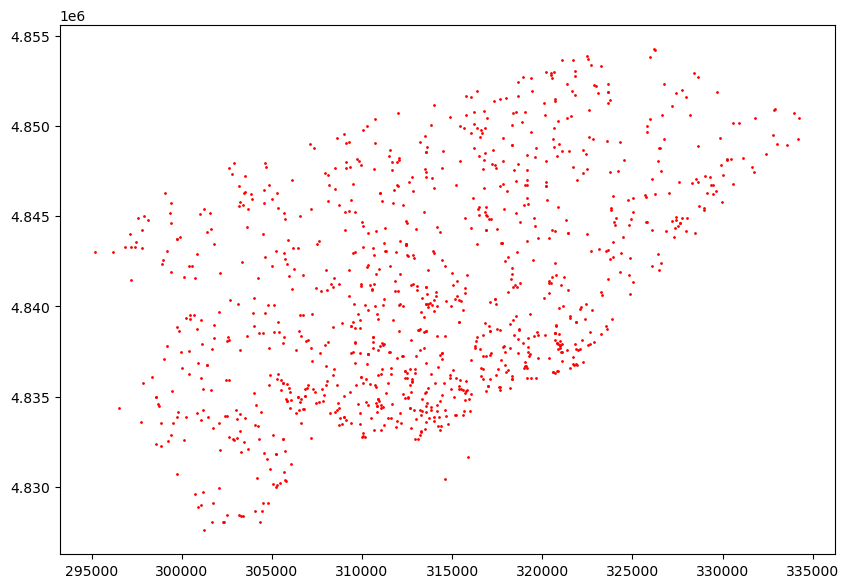

In [8]:
ax = ccc.plot(figsize=(10, 10),color='red', markersize =1)

## Read Pedestrian Network Data
Read the Pedestrian Network line shape file and reproject to EPSG 2019

In [9]:
# reading pednet file
pednet = gpd.read_file("Pedestrian Network Data - 4326.zip")
pednet

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry
0,696841,1,Local,7,Sidewalk on both sides,0,None,NaN,None,93.867680,129.824322,"LINESTRING (-79.56396 43.73782, -79.56293 43.7..."
1,696842,2,Collector,7,Sidewalk on both sides,0,None,NaN,None,32.546284,44.903807,"LINESTRING (-79.56792 43.63618, -79.56752 43.6..."
2,696843,3,None,2,Sidewalk on north side only,0,None,NaN,None,117.669206,162.522572,"LINESTRING (-79.37791 43.67845, -79.37652 43.6..."
3,696844,4,None,7,Sidewalk on both sides,0,None,NaN,None,223.269710,309.035596,"LINESTRING (-79.51852 43.70501, -79.51674 43.7..."
4,696845,5,Local,7,Sidewalk on both sides,0,None,NaN,None,201.335648,278.478601,"LINESTRING (-79.30122 43.77484, -79.29880 43.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...
87100,783941,87101,Walkway,11,City walkway,1,ts,1430.0,ts,32.249129,44.584927,"LINESTRING (-79.57840 43.73537, -79.57803 43.7..."
87101,783942,87102,Walkway,11,City walkway,1,ts,1174.0,ts,26.786411,37.023492,"LINESTRING (-79.57050 43.71929, -79.57019 43.7..."
87102,783943,87103,Walkway,11,City walkway,1,ts,888.0,ts,32.846849,45.381530,"LINESTRING (-79.56002 43.69689, -79.55964 43.6..."
87103,783944,87104,Walkway,11,City walkway,1,ts,2137.0,ts,30.031629,41.511419,"LINESTRING (-79.57363 43.72572, -79.57327 43.7..."


In [10]:
pednet.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
pednet = pednet.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
# remove length column to avoid confusion
# pednet = pednet[['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk', 'cwalk_type', 'px', 'px_type','geometry']]
pednet = pednet[['FIELD_1', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_7', 'FIELD_8', 'FIELD_9','geometry']]
pednet

,FIELD_1,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,geometry
0,696841,Local,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (299629.361 4843986.533, 299712.524..."
1,696842,Collector,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (299301.418 4832694.998, 299333.845..."
2,696843,None,2,Sidewalk on north side only,0,None,NaN,None,"LINESTRING (314625.445 4837396.458, 314737.453..."
3,696844,None,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (303289.064 4840340.134, 303432.612..."
4,696845,Local,7,Sidewalk on both sides,0,None,NaN,None,"LINESTRING (320783.543 4848116.285, 320977.983..."
...,...,...,...,...,...,...,...,...,...
87100,783941,Walkway,11,City walkway,1,ts,1430.0,ts,"LINESTRING (298466.037 4843715.753, 298496.245..."
87101,783942,Walkway,11,City walkway,1,ts,1174.0,ts,"LINESTRING (299101.091 4841927.995, 299126.266..."
87102,783943,Walkway,11,City walkway,1,ts,888.0,ts,"LINESTRING (299943.498 4839438.759, 299974.606..."
87103,783944,Walkway,11,City walkway,1,ts,2137.0,ts,"LINESTRING (298849.989 4842642.299, 298878.282..."


## Explore the Pedestrian Network Data
Create bar plot and plots of pednet

Create a bar plot showing the distribution of road types

<AxesSubplot:title={'center':'Pednet Road Type Distribution'}, xlabel='Road Types ', ylabel='Number'>

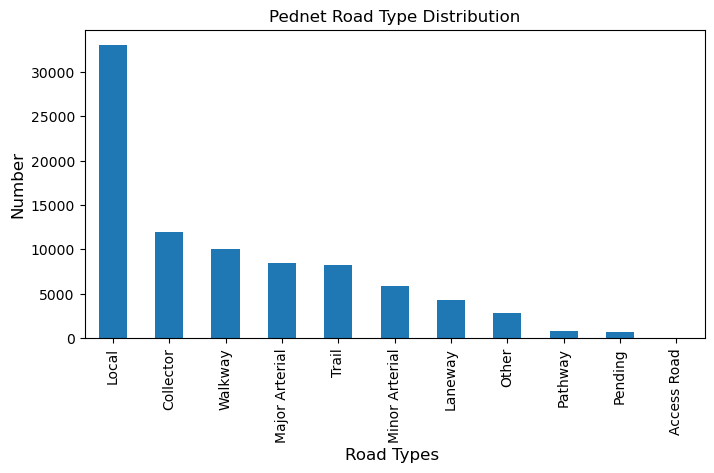

In [13]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.FIELD_3.value_counts().plot.bar()

### Create a plot of the city wide Pedestrian Network

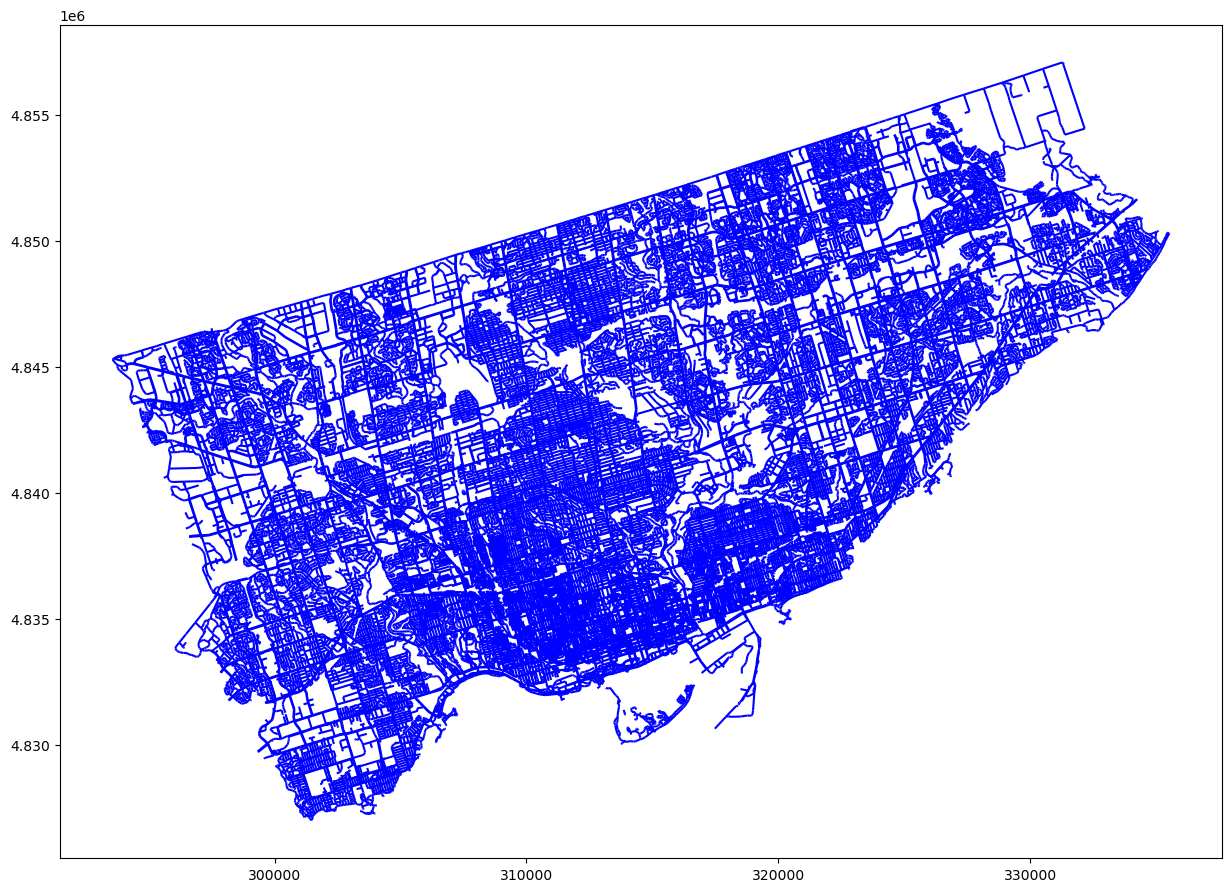

In [14]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the Pedestrian Network at the city block level
In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.

[(311000.0, 312000.0), (4834000.0, 4835000.0)]

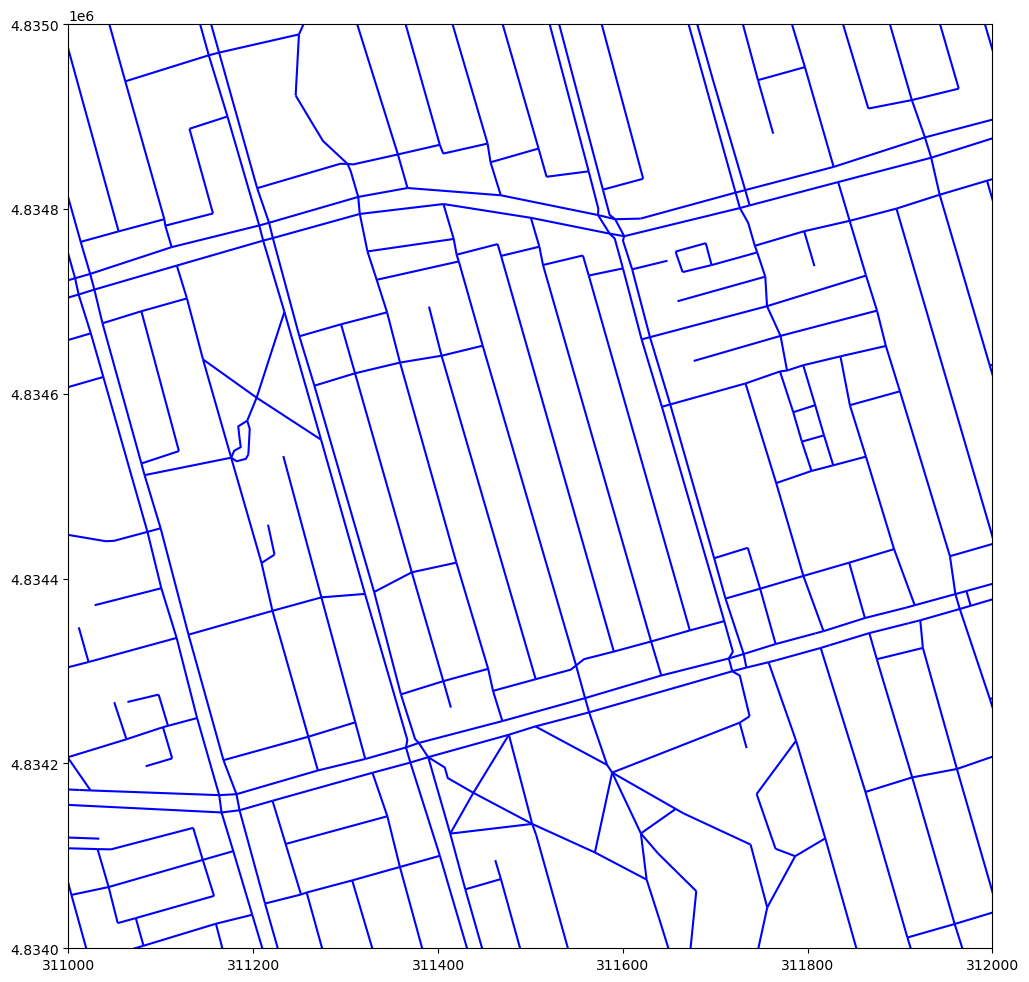

In [15]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

## Load TTC Stop Data
Read the TTC Stop file and reproject to EPSG 2019

In [18]:
# reading municipal bike_TE point shape file
# https://open.toronto.ca/dataset/bike_TE-points-municipal-toronto-one-bike_TE-repository/
# Go to Download Data
bike_TE = gpd.read_file("BICYCLE_TRAIL_ENTRANCE_WGS84.shp")
bike_TE

,ST_NAME,CR_ST_NAME,TRAIL_NAME,ACCESSIBLE,TYPE,STAIR_NUM,GRADE,IMPROVEMNT,SCOPE_WORK,X,Y,LONGITUDE,LATITUDE,OBJECTID,geometry
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,None,None,0,0,None,None,324474.245,4845739.724,-79.255494,43.753354,75,POINT (-79.25549 43.75335)
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,None,None,0,0,None,None,324492.968,4845777.592,-79.255260,43.753694,76,POINT (-79.25526 43.75369)
2,McCowan Rd,St Andrews Rd,Gatineau Trail,None,None,0,0,None,None,325155.599,4846495.005,-79.247004,43.760134,77,POINT (-79.24700 43.76013)
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,None,None,0,0,None,None,325851.462,4847064.897,-79.238340,43.765244,79,POINT (-79.23834 43.76524)
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,None,None,0,0,None,None,326139.506,4847321.038,-79.234752,43.767541,80,POINT (-79.23475 43.76754)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,None,None,0,0,None,None,324083.364,4846499.405,-79.260321,43.760202,513,POINT (-79.26032 43.76020)
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,None,None,0,0,None,None,327610.038,4851417.555,-79.216314,43.804371,543,POINT (-79.21631 43.80437)
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,None,None,0,0,None,None,320347.992,4851022.155,-79.306581,43.800999,574,POINT (-79.30658 43.80100)
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,None,None,0,0,None,None,318963.445,4851542.278,-79.323774,43.805708,602,POINT (-79.32377 43.80571)


In [19]:
# change column names from upper to lower case
bike_TE.columns = map(str.lower, bike_TE.columns)

In [20]:
#include columns needed for the project
bike_TE = bike_TE[['st_name', 'cr_st_name','trail_name','x','y','longitude','latitude','objectid','geometry']]
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (-79.25549 43.75335)
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (-79.25526 43.75369)
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (-79.24700 43.76013)
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (-79.23834 43.76524)
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (-79.23475 43.76754)
...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (-79.26032 43.76020)
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (-79.21631 43.80437)
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (-79.30658 43.80100)
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (-79.32377 43.80571)


In [21]:
bike_TE.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
bike_TE = gpd.GeoDataFrame(bike_TE, crs=crs, geometry='geometry')
bike_TE = bike_TE.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore bike_TE point data

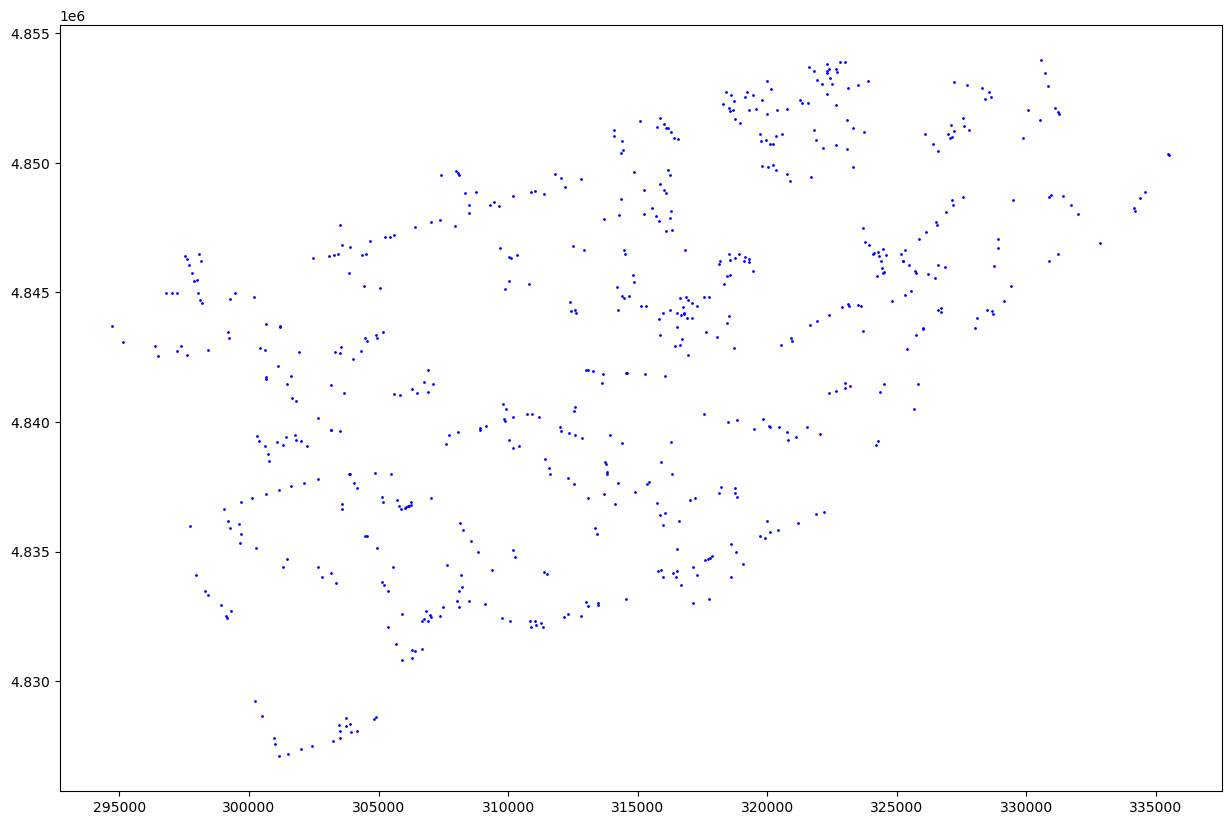

In [23]:
ax = bike_TE.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the bike_TE point data at the city block level


[(311200.0, 311800.0), (4834200.0, 4834800.0)]

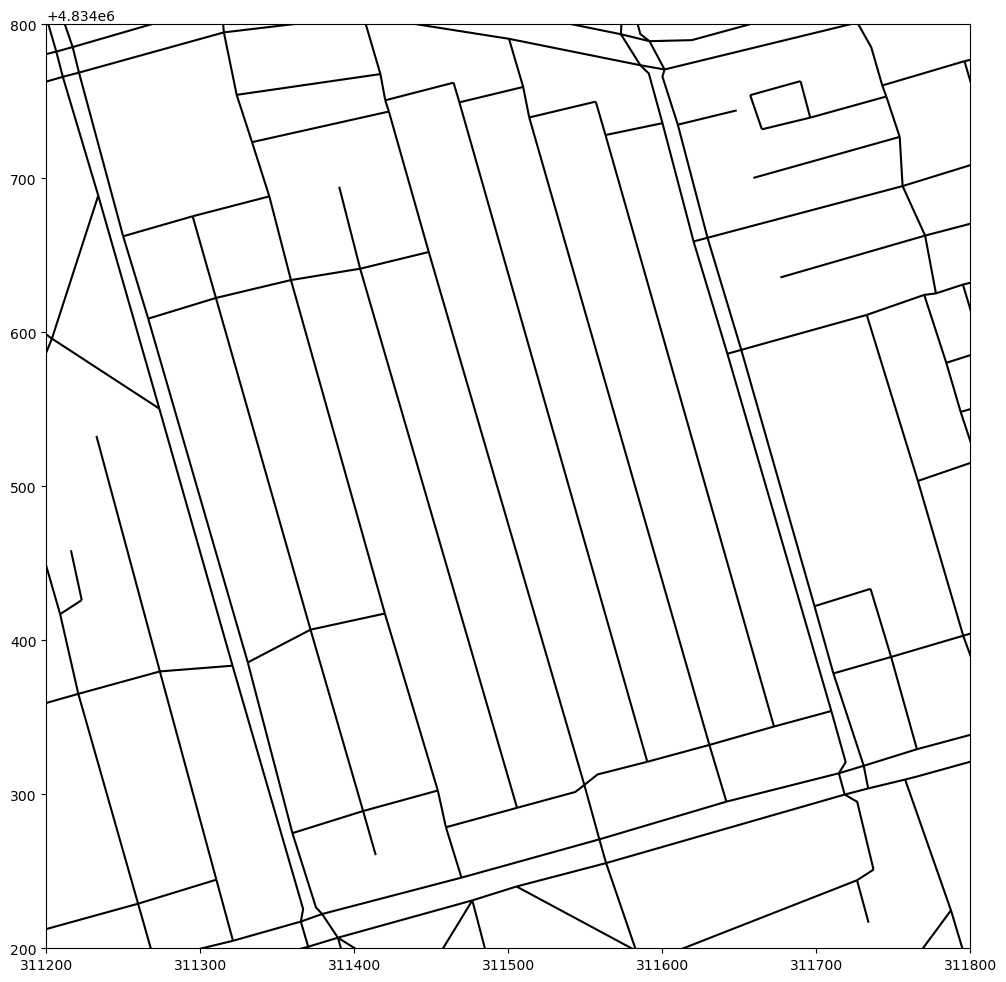

In [24]:
# plotting bike_TE layer with limits set
ax = bike_TE.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

## Neighbourhood Improvement Areas
Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [25]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("neighbourhood-improvement-areas-wgs84.zip")
nia

,AREA_ID,DATE_EFF,DATE_EXP,AREA_AT_ID,AREA_TP_ID,PARNT_AREA,AREA_TYPE,AREA_CL_ID,AREA_CL,AREA_S_CD,...,FEAT_CD,FEAT_C_DSC,TR_ID_CRT,TR_ID_EXP,X,Y,LONGITUDE,LATITUDE,OBJECTID,geometry
0,25886593,2014-05-12,3000-01-01,25926665,602,49885,CNBH,0,None,027,...,0,None,105211,-1,305679.417,4847086.588,-79.488883,43.765736,16491553.0,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,2014-05-12,3000-01-01,25926718,602,49885,CNBH,0,None,003,...,0,None,105211,-1,299670.030,4844005.846,-79.563491,43.737988,16492401.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,2014-05-12,3000-01-01,25926719,602,49885,CNBH,0,None,055,...,0,None,105211,-1,316874.178,4840655.317,-79.349984,43.707749,16492417.0,"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,2014-05-12,3000-01-01,25926708,602,49885,CNBH,0,None,028,...,0,None,105211,-1,304938.033,4841073.295,-79.498091,43.711609,16492241.0,"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,2014-05-12,3000-01-01,25926709,602,49885,CNBH,0,None,139,...,0,None,105211,-1,327594.737,4844116.308,-79.216813,43.738652,16492257.0,"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."
5,25886994,2014-05-12,3000-01-01,25926710,602,49885,CNBH,0,None,085,...,0,None,105211,-1,309678.766,4832752.918,-79.439338,43.636700,16492273.0,"POLYGON ((-79.42778 43.62979, -79.42948 43.630..."
6,25886342,2014-05-12,3000-01-01,25926716,602,49885,CNBH,0,None,061,...,0,None,105211,-1,321236.202,4839247.968,-79.295901,43.694998,16492369.0,"POLYGON ((-79.28776 43.68978, -79.29269 43.688..."
7,25886613,2014-05-12,3000-01-01,25926790,602,49885,CNBH,0,None,021,...,0,None,105211,-1,300261.014,4846330.825,-79.556175,43.758920,16493553.0,"POLYGON ((-79.58064 43.76302, -79.57754 43.763..."
8,25886658,2014-05-12,3000-01-01,25926791,602,49885,CNBH,0,None,022,...,0,None,105211,-1,301371.929,4844609.257,-79.542367,43.743430,16493569.0,"POLYGON ((-79.52628 43.73640, -79.52649 43.736..."
9,25886693,2014-05-12,3000-01-01,25926778,602,49885,CNBH,0,None,044,...,0,None,105211,-1,318269.615,4841566.821,-79.332646,43.715930,16493361.0,"POLYGON ((-79.33791 43.70770, -79.33788 43.707..."


In [26]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia

,area_id,area_s_cd,area_name,geometry
0,25886593,027,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,003,Thistletown-Beaumond Heights (3),"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,055,Thorncliffe Park (55),"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,028,Rustic (28),"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,139,Scarborough Village (139),"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."
5,25886994,085,South Parkdale (85),"POLYGON ((-79.42778 43.62979, -79.42948 43.630..."
6,25886342,061,Taylor-Massey (61),"POLYGON ((-79.28776 43.68978, -79.29269 43.688..."
7,25886613,021,Humber Summit (21),"POLYGON ((-79.58064 43.76302, -79.57754 43.763..."
8,25886658,022,Humbermede (22),"POLYGON ((-79.52628 43.73640, -79.52649 43.736..."
9,25886693,044,Flemingdon Park (44),"POLYGON ((-79.33791 43.70770, -79.33788 43.707..."


In [27]:
nia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Explore Neighbourhood Improvement Areas

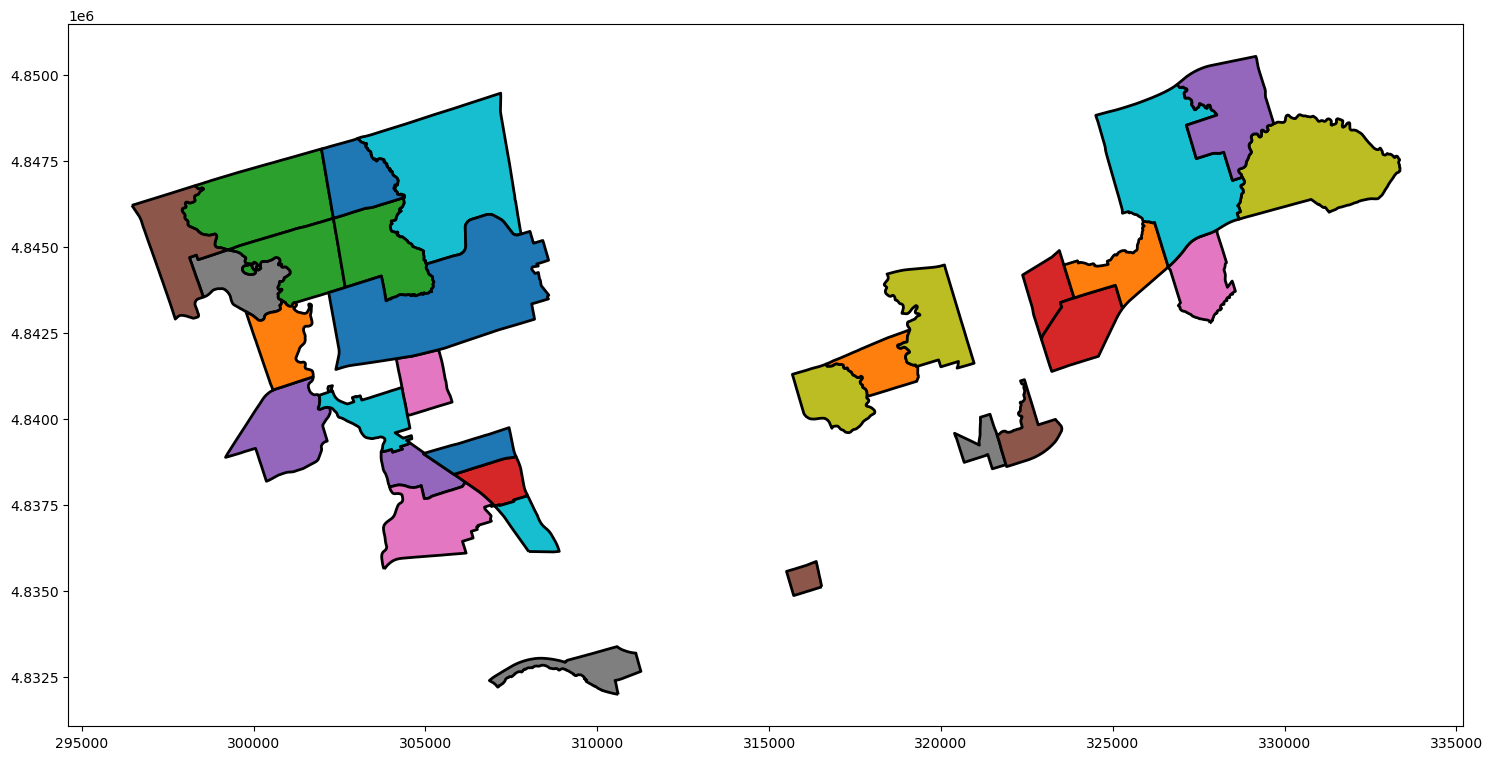

In [29]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)

# Step 2: Build Pandana Network
Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers.

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

## Create Network Graph Code Function

In [30]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Create a network graph from the function above


In [31]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [32]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [33]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges

,from,to,FIELD_7,visited,FIELD_6,length,FIELD_8,forward,FIELD_4,FIELD_1,FIELD_5,geometry,FIELD_9,FIELD_3,to_node,from_node
0,"(299629.361, 4843986.533)","(299712.524, 4843942.995)",None,0,0,93.869779,NaN,1,7,696841,Sidewalk on both sides,LINESTRING (299629.36127988406 4843986.5326587...,None,Local,36146,45199
1,"(299629.361, 4843986.533)","(299584.522, 4844056.343)",None,0,0,82.970624,NaN,1,7,780939,Sidewalk on both sides,LINESTRING (299584.5218131868 4844056.34345040...,None,Local,9132,45199
2,"(299712.524, 4843942.995)","(299793.811, 4843900.999)",None,0,0,91.494389,NaN,1,3,722552,No sidewalk on either side,LINESTRING (299712.52356601635 4843942.9945202...,None,Local,40282,36146
3,"(299712.524, 4843942.995)","(299765.404, 4844026.466)",None,0,0,98.812456,NaN,1,7,738428,Sidewalk on both sides,LINESTRING (299712.52356601635 4843942.9945202...,None,Local,31640,36146
4,"(299301.418, 4832694.998)","(299333.845, 4832692.213)",None,0,0,32.546192,NaN,1,7,696842,Sidewalk on both sides,LINESTRING (299301.41839780845 4832694.9977099...,None,Collector,61830,15694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87091,"(327210.501, 4852959.717)","(327218.427, 4853009.11)",None,0,0,50.025307,NaN,1,7,781934,Sidewalk on both sides,LINESTRING (327210.5009090444 4852959.71697141...,None,Minor Arterial,14497,46720
87092,"(307033.159, 4834704.709)","(307038.089, 4834687.599)",None,0,0,17.806012,NaN,1,7,781991,Sidewalk on both sides,LINESTRING (307033.1591026859 4834704.70866125...,None,Local,43577,51539
87093,"(309323.594, 4837272.392)","(309266.163, 4837253.926)",None,0,0,60.326333,NaN,1,10,783712,Laneway without any sidewalks,LINESTRING (309266.1631502248 4837253.92582768...,None,Laneway,13456,52734
87094,"(321382.532, 4836948.084)","(321430.845, 4836942.929)",None,0,0,48.587159,NaN,1,10,783735,Laneway without any sidewalks,LINESTRING (321382.53223816346 4836948.0837029...,None,Laneway,33266,16603


### Creating and Saving Pandana Network
Create the Pandana Network and save the file in case you lose the network in memory

In [34]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')

### Reading Pandana Network file
This step is only required if you do not already have transit_ped_net in memory

In [35]:
transit_ped_net = pdna.Network.from_hdf5('walkability.hd5')

### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [36]:
#precompute a given horizon distance of 1000 meters
transit_ped_net.precompute(1000)
transit_ped_net.edges_df

,from,to,length
0,45199,36146,93.869779
1,45199,9132,82.970624
2,36146,40282,91.494389
3,36146,31640,98.812456
4,15694,61830,32.546192
...,...,...,...
87091,46720,14497,50.025307
87092,51539,43577,17.806012
87093,52734,13456,60.326333
87094,16603,33266,48.587159


#### Get the nearest pednet intersection node ids for each point from the bike_TE and CCC layers

In [37]:
#get node_ids for points for each layer
x, y = ccc.x, ccc.y
ccc["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(ccc["node_ids"], name="ccc")

# using x and y coordinates from bike_TE that are utm nad27
x, y = bike_TE.x, bike_TE.y
bike_TE["node_ids"] = transit_ped_net.get_node_ids(x, y)

#### Get 10 nearest CCC points
The 10 nearest CCCs will be determined.

In [38]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("ccc", maxdistance , n, ccc.x, ccc.y)
ccc_walk_distances = transit_ped_net.nearest_pois(maxdistance , "ccc", num_pois=n, include_poi_ids=False)

ccc_walk_distances

,1,2,3,4,5,6,7,8,9,10
0,447.773987,447.773987,538.254028,598.856018,598.856018,1162.364990,1293.633057,1477.968994,1561.826050,1574.583008
1,865.064026,1527.741943,2116.534912,2569.956055,2612.488037,2669.782959,2784.145996,3388.354980,3461.601074,3521.186035
2,884.526978,1104.334961,1129.140991,1231.239990,1257.302002,1487.427002,1677.711060,1727.401001,1761.483032,1881.715942
3,258.122009,347.959015,389.924988,494.708008,534.872986,591.070007,755.002014,1491.234009,1640.524048,1694.464966
4,591.315979,672.172974,870.208008,1281.490967,1356.541992,1370.183960,1525.646973,1529.832031,1529.832031,1584.161011
...,...,...,...,...,...,...,...,...,...,...
64710,654.205017,697.773987,773.651978,875.051025,890.598999,1139.968018,1155.711060,1315.035034,1366.776978,1431.663940
64711,863.106018,1268.461060,1364.556030,1462.583008,1500.923950,1500.923950,1536.552002,1574.703979,1578.301025,1731.788940
64712,414.260986,813.724976,1328.786987,1942.449951,1965.557983,1965.557983,2064.027100,2076.690918,2176.492920,2245.125977
64713,0.000000,286.127014,286.127014,496.825012,968.181030,1048.235962,1133.479004,1260.029053,1488.229004,1602.012939


#### Renaming columns

In [39]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

ccc_walk_distances.columns = columns
ccc_walk_distances

,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,447.773987,447.773987,538.254028,598.856018,598.856018,1162.364990,1293.633057,1477.968994,1561.826050,1574.583008
1,865.064026,1527.741943,2116.534912,2569.956055,2612.488037,2669.782959,2784.145996,3388.354980,3461.601074,3521.186035
2,884.526978,1104.334961,1129.140991,1231.239990,1257.302002,1487.427002,1677.711060,1727.401001,1761.483032,1881.715942
3,258.122009,347.959015,389.924988,494.708008,534.872986,591.070007,755.002014,1491.234009,1640.524048,1694.464966
4,591.315979,672.172974,870.208008,1281.490967,1356.541992,1370.183960,1525.646973,1529.832031,1529.832031,1584.161011
...,...,...,...,...,...,...,...,...,...,...
64710,654.205017,697.773987,773.651978,875.051025,890.598999,1139.968018,1155.711060,1315.035034,1366.776978,1431.663940
64711,863.106018,1268.461060,1364.556030,1462.583008,1500.923950,1500.923950,1536.552002,1574.703979,1578.301025,1731.788940
64712,414.260986,813.724976,1328.786987,1942.449951,1965.557983,1965.557983,2064.027100,2076.690918,2176.492920,2245.125977
64713,0.000000,286.127014,286.127014,496.825012,968.181030,1048.235962,1133.479004,1260.029053,1488.229004,1602.012939


#### Calculating walk distance from bike_TE points to cccs and get each point id from CCC.


In [40]:
for i in range(10):
    bike_TE['d_ttcstop_{}'.format(i)]=bike_TE['node_ids'].map(ccc_walk_distances['d_ttcstop_{}'.format(i)])
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry,node_ids,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (324471.707 4845739.364),43280,366.015991,734.718018,784.531006,815.585999,986.492004,1085.034058,1118.543945,1132.479980,1293.521973,1301.056030
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (324490.431 4845777.233),51234,301.221985,738.340027,819.450012,846.281982,1048.243042,1083.272949,1143.733032,1183.760010,1294.930054,1358.531006
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (325153.061 4846494.639),21746,638.119019,852.648987,1008.041016,1080.390991,1392.744995,1432.525024,1494.384033,1527.702026,1693.921997,1781.576050
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (325848.915 4847064.551),27221,538.468994,1027.510010,1032.000000,1071.760010,1222.506958,1253.688965,1555.985962,1925.907959,2063.965088,2143.520020
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (326136.951 4847320.692),39168,421.959015,631.666992,853.939026,1258.561035,1425.448975,1620.446045,1746.239014,1758.375000,1956.318970,2061.775879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (324080.805 4846499.032),8037,524.276978,1315.353027,1328.500000,1355.107056,1596.057007,1765.618042,1798.017944,1846.728027,2034.235962,2159.750000
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (327607.398 4851417.253),49802,505.786987,622.130981,720.390015,811.455017,1319.171997,1357.176025,1698.019043,1966.786011,2251.532959,2471.471924
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (320345.292 4851021.636),37328,421.726990,608.953979,736.822998,911.088989,1026.214966,1258.395020,1631.922974,1668.088989,1704.238037,1837.713989
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (318960.738 4851541.688),14353,342.631989,668.533997,1006.198975,1145.911011,1219.036987,1272.493042,1331.147949,1389.453979,1436.685059,1643.477051


#### Calculate minutes fields based on distances
We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [41]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

bike_TE['m_ttcstop_0'] = bike_TE.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
bike_TE['m_ttcstop_1'] = bike_TE.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
bike_TE['m_ttcstop_2'] = bike_TE.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
bike_TE['m_ttcstop_3'] = bike_TE.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
bike_TE['m_ttcstop_4'] = bike_TE.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
bike_TE['m_ttcstop_5'] = bike_TE.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
bike_TE['m_ttcstop_6'] = bike_TE.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
bike_TE['m_ttcstop_7'] = bike_TE.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
bike_TE['m_ttcstop_8'] = bike_TE.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
bike_TE['m_ttcstop_9'] = bike_TE.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
bike_TE

,st_name,cr_st_name,trail_name,x,y,longitude,latitude,objectid,geometry,node_ids,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,Brimley Rd,Lawrence Ave E,Gatineau Trail,324474.245,4845739.724,-79.255494,43.753354,75,POINT (324471.707 4845739.364),43280,...,5.083555,10.204417,10.896264,11.327583,13.701278,15.069917,15.535333,15.728889,17.965583,18.070223
1,Brimley Rd,Lawrence Ave E,Gatineau Trail,324492.968,4845777.592,-79.255260,43.753694,76,POINT (324490.431 4845777.233),51234,...,4.183639,10.254723,11.381250,11.753916,14.558931,15.045458,15.885181,16.441111,17.985140,18.868486
2,McCowan Rd,St Andrews Rd,Gatineau Trail,325155.599,4846495.005,-79.247004,43.760134,77,POINT (325153.061 4846494.639),21746,...,8.862764,11.842347,14.000570,15.005430,19.343680,19.896181,20.755334,21.218084,23.526694,24.744112
3,Bellamy Rd N,Jarwick Dr,Gatineau Trail,325851.462,4847064.897,-79.238340,43.765244,79,POINT (325848.915 4847064.551),27221,...,7.478736,14.270972,14.333333,14.885556,16.979263,17.412347,21.610916,26.748722,28.666182,29.771111
4,Daventry Rd,Dolly Varden Blvd,Gatineau Trail,326139.506,4847321.038,-79.234752,43.767541,80,POINT (326136.951 4847320.692),39168,...,5.860542,8.773153,11.860264,17.480014,19.797902,22.506195,24.253320,24.421875,27.171097,28.635776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,Pomeroy St,Freeborn Cres,West Highland Creek Trail,324083.364,4846499.405,-79.260321,43.760202,513,POINT (324080.805 4846499.032),8037,...,7.281625,18.268792,18.451389,18.820931,22.167458,24.522473,24.972471,25.649000,28.253277,29.996528
624,Silverbell Grv,50 Sliverbell Grv,WicksonTrail Park Trail,327610.038,4851417.555,-79.216314,43.804371,543,POINT (327607.398 4851417.253),49802,...,7.024819,8.640708,10.005417,11.270209,18.321833,18.849667,23.583598,27.316472,31.271291,34.325999
625,SliverSprings Blvd,Birchmount Rd,West Highland Creek Trail,320347.992,4851022.155,-79.306581,43.800999,574,POINT (320345.292 4851021.636),37328,...,5.857319,8.457694,10.233653,12.654014,14.252986,17.477709,22.665597,23.167903,23.669973,25.523805
626,McNicoll Ave,Stonebridge Blvd,L'Amoreaux Trail,318963.445,4851542.278,-79.323774,43.805708,602,POINT (318960.738 4851541.688),14353,...,4.758778,9.285194,13.974986,15.915431,16.931069,17.673514,18.488166,19.297972,19.953959,22.826070


# Step 3: Visualize Walking Times
In this step we will create a series of visulations illustrating the walking times to the nearest CCC across the pedestrian network.

## Walking Times To Closest CCC
In this section we will create a chloropleth map showing the walk times to the closest CCC across the City of Toronto. As expected the shortest walk times are along majorial aerterials where CCCs are located as shown in the second map below where the CCCs are colour coded red.

Text(0.5, 1.0, 'Walking Times To Closest CCC')

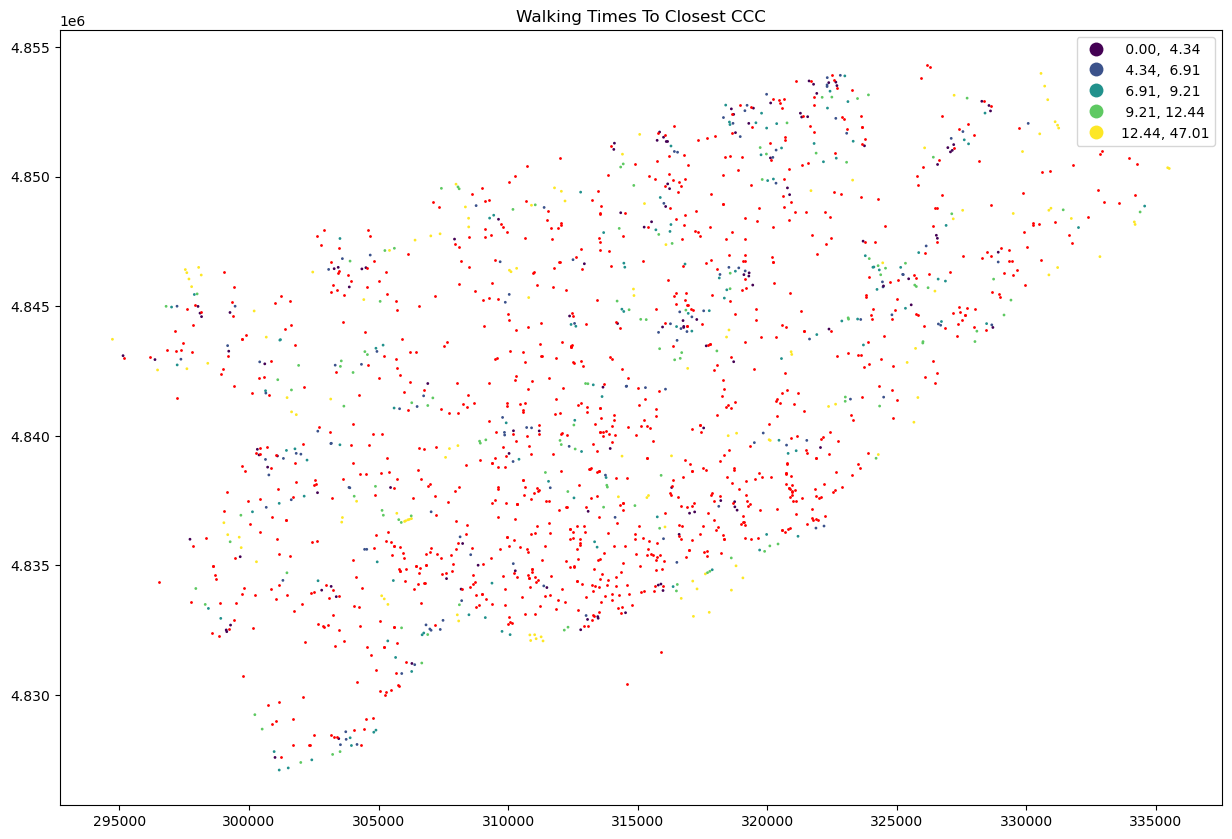

In [42]:
# Walking times To closest CCC with CCCs added
import mapclassify
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
ccc.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest CCC')

## Walking Times To Closest CCC with Neighbourhood Improvement Areas

In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

## Get the Neighbourhood Improvement Area centre points

To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [43]:
# Here we find the center points, copy our original df to a new df, and then set
# the geometry column to the newly created center points column
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

Text(0.5, 1.0, 'Walking Times To Closest CCC \n within Neighbourhood Improvement Areas')

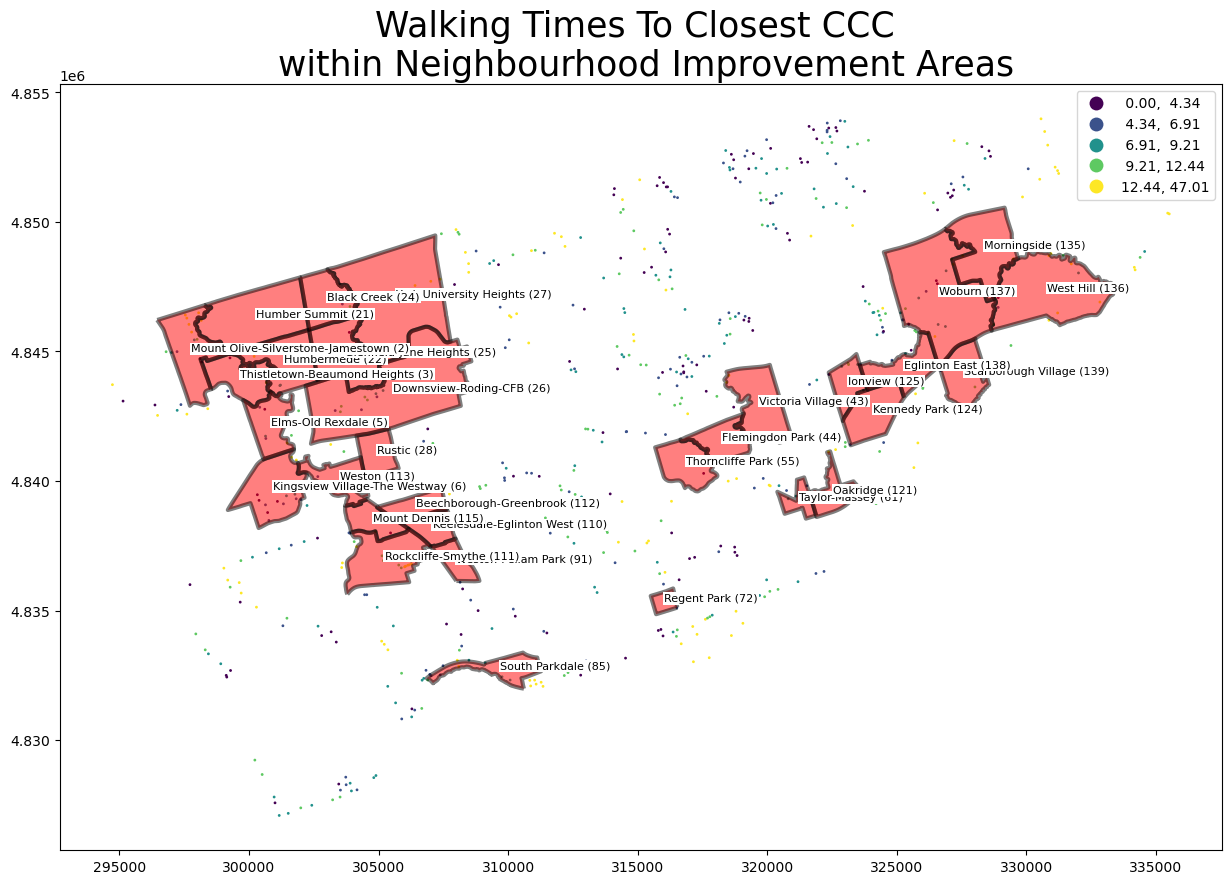

In [44]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest CCC \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

# bike_TEes within Neighbourhood Improvement Areas

We will now perform a spatial join between Neighbourhood Improvement Area layer and bike_TE layer in order to allocate bike_TEes to Neighbourhood Improvement Areas.

In [45]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with bike_TE points
nia_bike_TE = gpd.sjoin(nia, bike_TE, op='intersects', how='left')
nia_bike_TE

C:\Users\humbe\anaconda3\envs\environment\lib\site-packages\IPython\core\interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,12.080889,15.505334,16.339376,17.477444,17.701140,21.624195,24.991124,25.415166,26.802723,28.022819
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,13.611653,15.409027,16.295625,16.907500,18.694709,19.031333,21.029278,21.520860,22.045097,23.511500
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,0.313944,7.168459,11.639208,13.231750,15.525514,15.705487,15.931666,16.714681,18.437848,20.461305
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,5.612278,10.138430,12.809195,15.174820,17.215235,20.816973,21.463694,21.565292,23.028680,23.876431
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,11.252875,15.439958,16.613069,17.171471,17.367791,18.337723,22.402874,28.045027,28.693054,30.791985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,7.531472,10.356000,17.919195,19.015015,20.073235,22.890708,23.078320,23.937458,26.275736,28.562168
29,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,6.357500,11.796583,14.625070,17.580153,19.618083,23.823736,24.283542,24.408542,25.951180,27.226013
29,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,6.378750,11.313361,15.037764,18.063375,19.134861,23.925320,24.306958,24.766764,25.467958,26.742791
29,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,5.821653,9.047389,19.450584,19.657167,23.742472,32.269124,32.408875,33.811764,34.214152,35.086599


# Count of bike_TEes in Neighbourhood Improvement Areas

We will now do a count of bike_TEes within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [46]:
# count of bike_TEes assigned to each Neighbourhood Improvement Area
value_counts = nia_bike_TE.area_name.value_counts()
value_counts

Woburn (137)                             14
Mount Olive-Silverstone-Jamestown (2)    12
Rockcliffe-Smythe (111)                  12
York University Heights (27)             11
Kingsview Village-The Westway (6)        11
Downsview-Roding-CFB (26)                10
West Hill (136)                           8
South Parkdale (85)                       6
Elms-Old Rexdale (5)                      6
Black Creek (24)                          6
Ionview (125)                             5
Humbermede (22)                           4
Weston (113)                              4
Victoria Village (43)                     3
Thistletown-Beaumond Heights (3)          3
Scarborough Village (139)                 3
Taylor-Massey (61)                        3
Glenfield-Jane Heights (25)               2
Mount Dennis (115)                        2
Oakridge (121)                            2
Eglinton East (138)                       2
Thorncliffe Park (55)                     1
Rustic (28)                     

In [47]:
# count of bike_TEes assigned to each Neighbourhood Improvement Area
value_counts = nia_bike_TE.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_bike_TE_count
nia_bike_TE_counts = value_counts.rename_axis('area_name').reset_index(name='nia_bike_TE_count')
nia_bike_TE_counts

# merge nia_bike_TE_counts with nia_bike_TE using the area_name which is shared by both dataframes
nia_bike_TE = pd.merge(nia_bike_TE, nia_bike_TE_counts)

nia_bike_TE

,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_bike_TE_count
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,15.505334,16.339376,17.477444,17.701140,21.624195,24.991124,25.415166,26.802723,28.022819,11
1,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,15.409027,16.295625,16.907500,18.694709,19.031333,21.029278,21.520860,22.045097,23.511500,11
2,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,7.168459,11.639208,13.231750,15.525514,15.705487,15.931666,16.714681,18.437848,20.461305,11
3,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,10.138430,12.809195,15.174820,17.215235,20.816973,21.463694,21.565292,23.028680,23.876431,11
4,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,15.439958,16.613069,17.171471,17.367791,18.337723,22.402874,28.045027,28.693054,30.791985,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,10.356000,17.919195,19.015015,20.073235,22.890708,23.078320,23.937458,26.275736,28.562168,4
135,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,11.796583,14.625070,17.580153,19.618083,23.823736,24.283542,24.408542,25.951180,27.226013,4
136,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,11.313361,15.037764,18.063375,19.134861,23.925320,24.306958,24.766764,25.467958,26.742791,4
137,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,9.047389,19.450584,19.657167,23.742472,32.269124,32.408875,33.811764,34.214152,35.086599,4


<AxesSubplot:title={'center':'bike_TE Count in Neighbourhood Improvement Areas'}, xlabel='Neighbourhood Improvement Areas', ylabel='Number'>

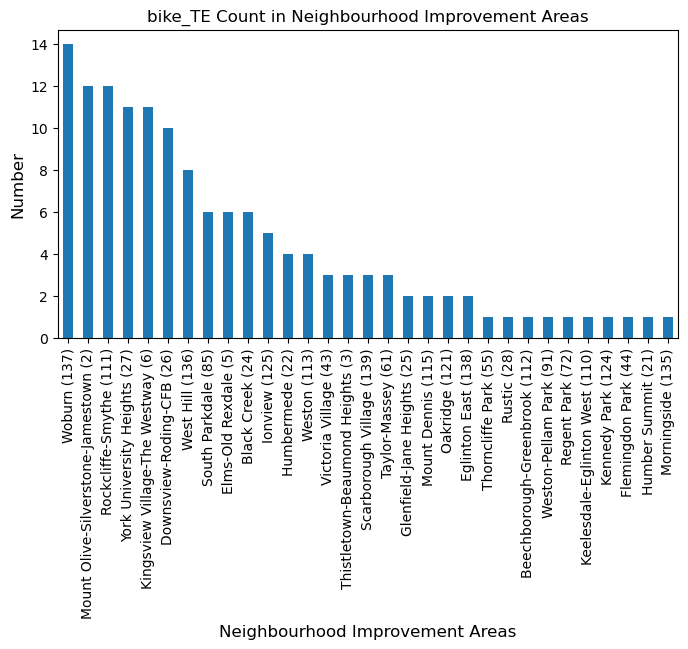

In [48]:
# distribution of bike_TEes in nia_bike_TE

#plot
plt.figure(figsize=(8,4))

plt.title("bike_TE Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_bike_TE.area_name.value_counts().plot.bar()

Text(0.5, 1.0, 'Walking Times To Closest CCC')

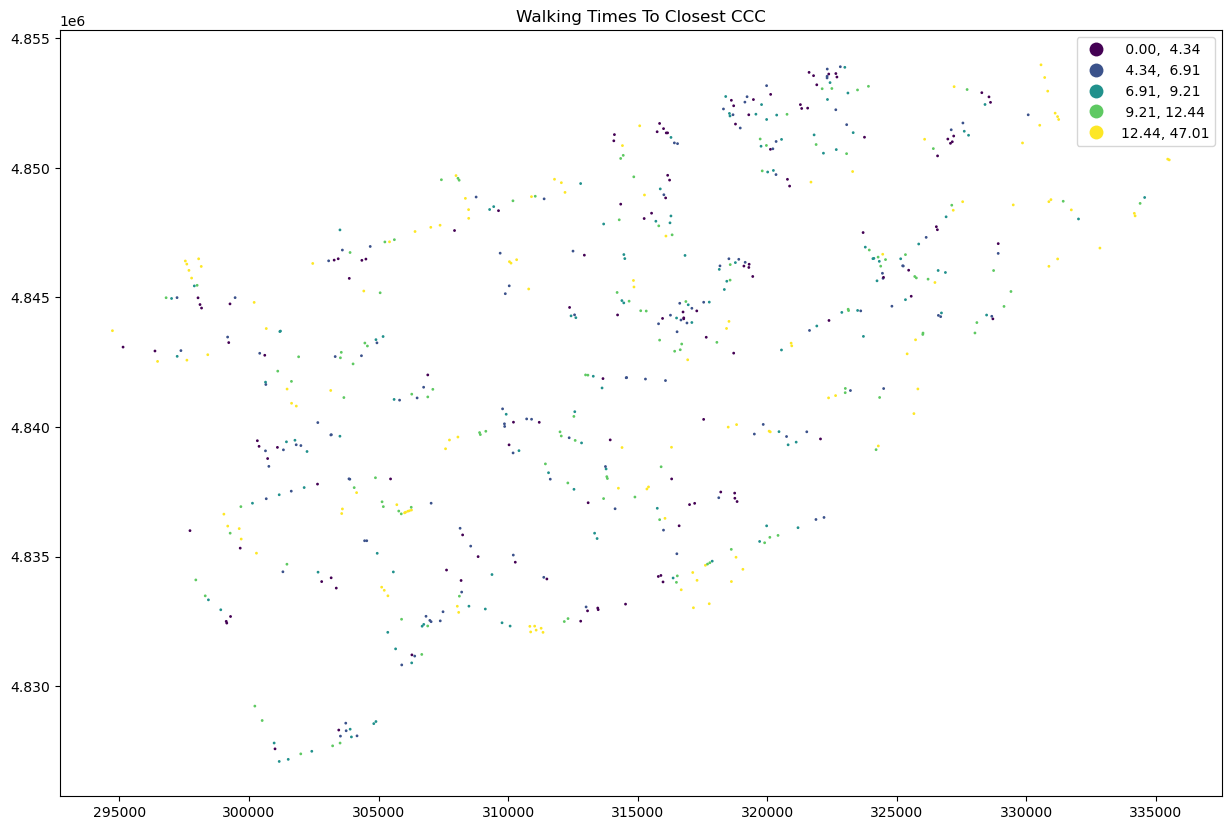

In [49]:
# Walking Times To Closest CCC
ax = bike_TE.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest CCC')

# Average Walking Times To Closest CCC in Neighbourhood Improvement Areas

We will now use the mean function to calculate the mean walking time to the closest CCC for each of the Neighbourhood Improvement Areas.

In [50]:
mins_avgs = nia_bike_TE.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)                  NaN
Black Creek (24)                          6.590752
Downsview-Roding-CFB (26)                 8.473397
Eglinton East (138)                       8.091090
Elms-Old Rexdale (5)                      7.906970
Flemingdon Park (44)                           NaN
Glenfield-Jane Heights (25)               3.040542
Humber Summit (21)                       17.139820
Humbermede (22)                           9.253364
Ionview (125)                             9.902803
Keelesdale-Eglinton West (110)                 NaN
Kennedy Park (124)                        6.659445
Kingsview Village-The Westway (6)         4.659814
Morningside (135)                        13.091416
Mount Dennis (115)                        6.422542
Mount Olive-Silverstone-Jamestown (2)    11.112635
Oakridge (121)                           10.463945
Regent Park (72)                          6.237681
Rockcliffe-Smythe (111)                  12.328759
Rustic (28)          

In [51]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_bike_TE with nia_addr_avg_min using area_name
nia_bike_TE = pd.merge(nia_bike_TE, nia_addr_avg_min)

nia_bike_TE

,area_id,area_s_cd,area_name,geometry,center,index_right,st_name,cr_st_name,trail_name,x,...,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_bike_TE_count,nia_addr_avg_min
0,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),504.0,Stilecroft Dr,Sentinel Rd,BlackCreek Trail,305064.255,...,16.339376,17.477444,17.701140,21.624195,24.991124,25.415166,26.802723,28.022819,11,11.781068
1,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),141.0,Grandravine Dr,Ollerton Rd,Black Creek Trail,304432.693,...,16.295625,16.907500,18.694709,19.031333,21.029278,21.520860,22.045097,23.511500,11,11.781068
2,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),143.0,Finch Ave W,Sentinel Rd,Black Creek Trail,304514.431,...,11.639208,13.231750,15.525514,15.705487,15.931666,16.714681,18.437848,20.461305,11,11.781068
3,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),149.0,Sentinel Rd,Murray Ross Pkwy,Finch Trail,304681.083,...,12.809195,15.174820,17.215235,20.816973,21.463694,21.565292,23.028680,23.876431,11,11.781068
4,25886593,027,York University Heights (27),"POLYGON ((304355.911 4846434.515, 304388.552 4...",POINT (305676.770 4847085.936),498.0,Columbia Gt,Murray Ross Pkwy,Finch Trail,305246.543,...,16.613069,17.171471,17.367791,18.337723,22.402874,28.045027,28.693054,30.791985,11,11.781068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),392.0,Hickory Tree Rd,Bellevue Cres,Humber River Trail,303511.676,...,17.919195,19.015015,20.073235,22.890708,23.078320,23.937458,26.275736,28.562168,4,6.522344
135,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),197.0,Lawrence Ave W,Little Ave,Humber River Trail,303160.285,...,14.625070,17.580153,19.618083,23.823736,24.283542,24.408542,25.951180,27.226013,4,6.522344
136,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),198.0,Lawrence Ave W,Hickory Tree Rd,Humber River Trail,303181.274,...,15.037764,18.063375,19.134861,23.925320,24.306958,24.766764,25.467958,26.742791,4,6.522344
137,25886362,113,Weston (113),"POLYGON ((304543.360 4839309.275, 304529.195 4...",POINT (303514.519 4840084.706),391.0,Weston Rd,Conron Pl,Humber River Trail,302657.545,...,19.450584,19.657167,23.742472,32.269124,32.408875,33.811764,34.214152,35.086599,4,6.522344


<AxesSubplot:xlabel='area_name'>

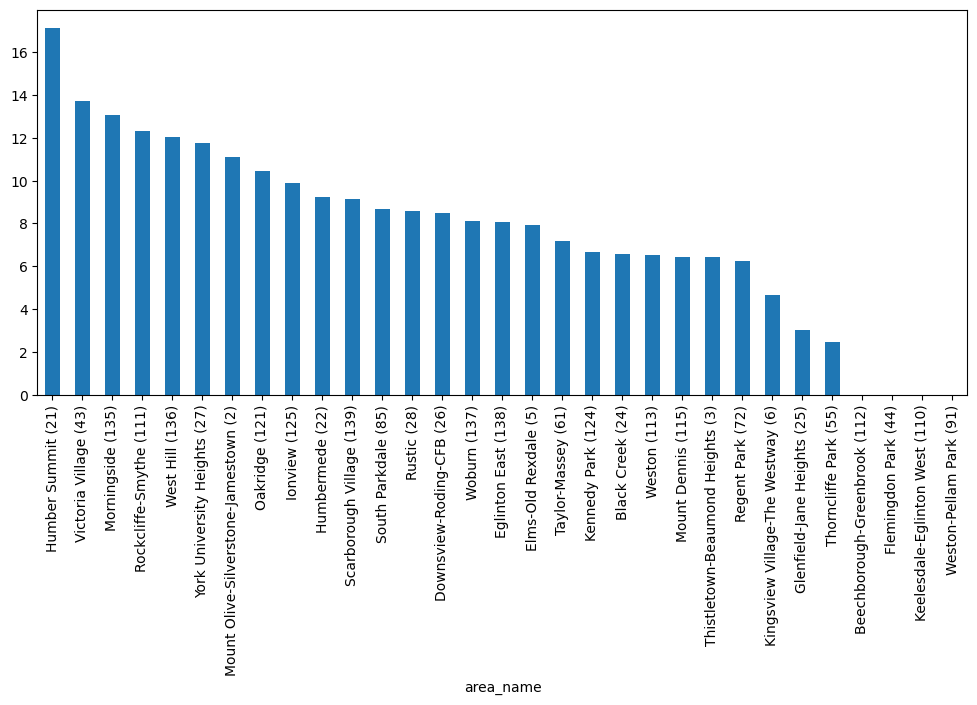

In [52]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_bike_TE_bar = nia_bike_TE.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_bike_TE_bar.sort_values(ascending=False).plot.bar()

# Plot Average Walking times to the Closest CCC for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

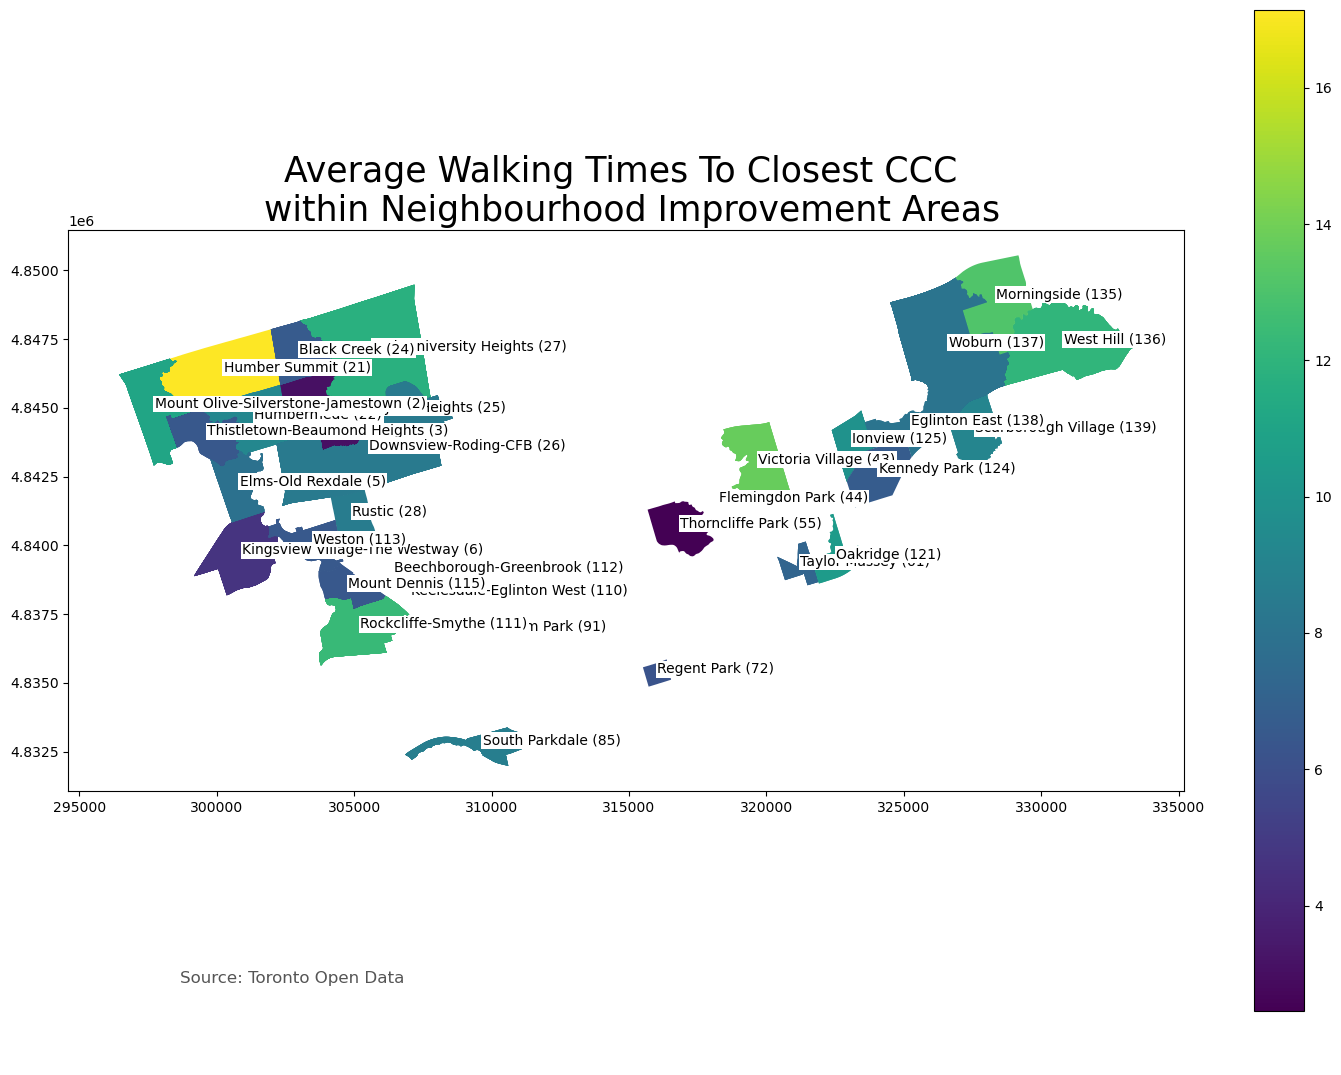

In [53]:
# plot Average Walking Times To Closest CCC in Neighbourhood Improvement Areas
ax = nia_bike_TE.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest CCC \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Get bounds of each Neighbourhood Improvement Area polygon

We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [54]:
# index_left and area_name
nia.area_name

0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                         Regen

In [55]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name
nia_area_name = nia.area_name.iloc[4]
nia_area_name

'Scarborough Village (139)'

# Plotting Neighbourhood Improvement Area using bounding box co-ordinates

Text(0.1, 0.05, 'Source: Toronto Open Data')

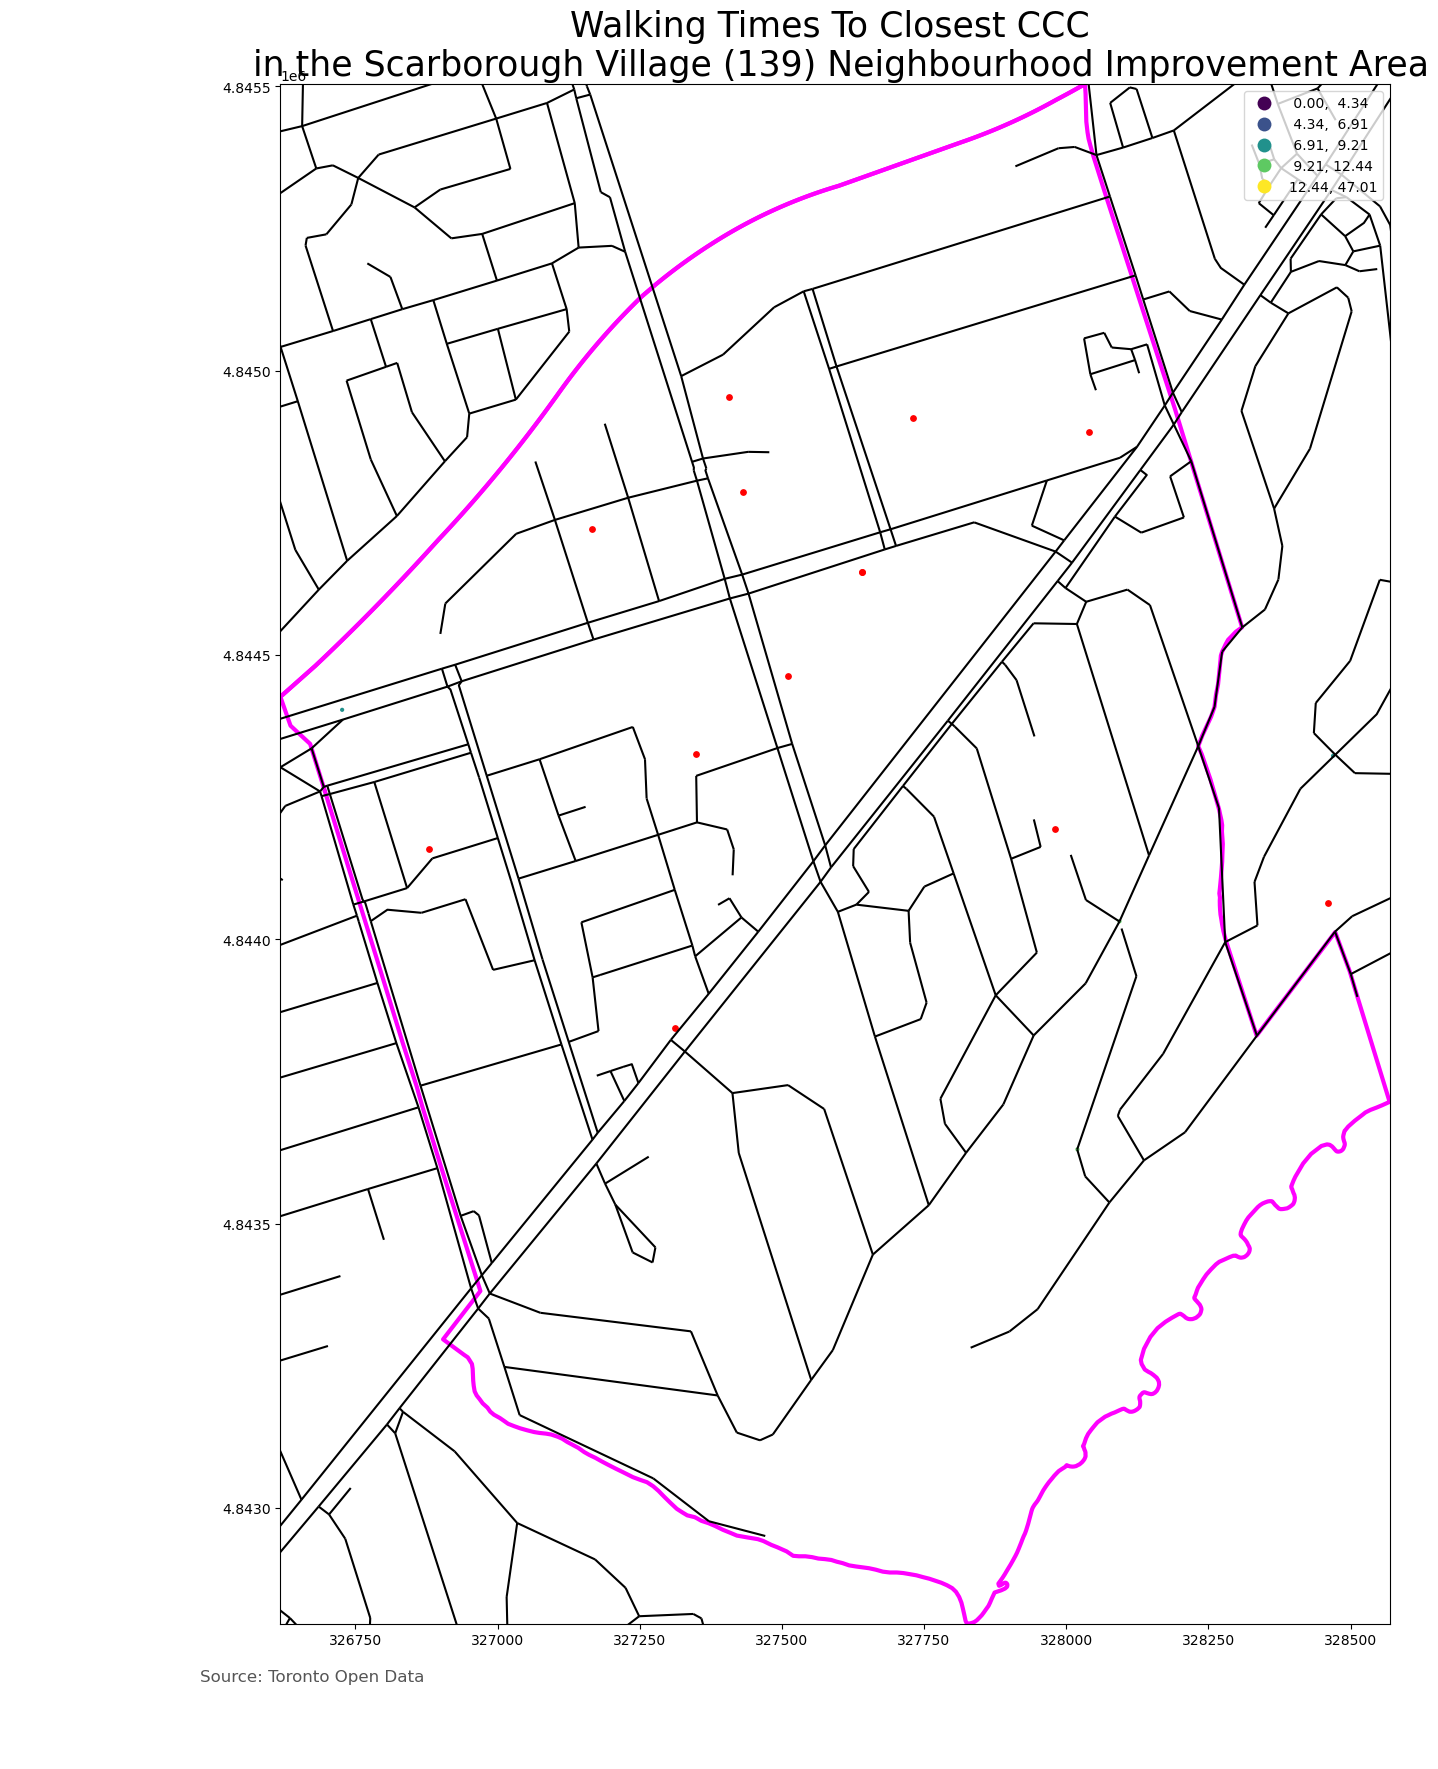

In [56]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = bike_TE.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
ccc.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest CCC \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./ccc_walkability.png", dpi=300)